In [1]:
import pandas as pd
import pickle
from PIL import Image
import numpy as np
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import shelve
import math
import numpy as np
import sys
import matplotlib.pyplot as plt
import scipy.stats as stats
import random
import pickle5 as pickle
import scipy.io
from scipy.stats import sem
import dataframe_image as dfi

In [2]:
##dataloader
from torch.utils.data import Dataset, DataLoader

class FaceDataset(Dataset):
    def __init__(self, txt_path, img_dir, transforms = None):
        df = pickle.load(open(txt_path, "rb"))
        df['img'] = df['img'].str.replace("/mmfs1/data/schwarex/neuralNetworks/identity/datasets/img_align_celeba",
                                          img_dir)
        self.txt_path = txt_path
        self.y = df['new_label']
        self.x = df['img']
        self.n_samples = len(df)
        self.transforms = transforms

        self.mu = torch.randn(1503)
        m = torch.distributions.gamma.Gamma(torch.ones(1503), torch.ones(1503) * 20)
        self.sigma = m.sample()

    def __len__(self):
        return self.n_samples


    def __getitem__(self, index):
        image = Image.open(self.x[index]).convert('RGB')

        if self.transforms:
            image = self.transforms(image)

        label = self.y[index]
        base_reward = torch.randn(1)
        reward = base_reward * self.sigma[label] + self.mu[label]
        data = [image, label, reward]

        return data

    
## RGB images   
transform = transforms.Compose([transforms.CenterCrop(178),  #original image size = (178, 218)
                                transforms.Resize(128),
                                transforms.ToTensor()])       


train_dataset = FaceDataset(txt_path = '/data/zhouabx/celebA/train_SUBSET.pkl',
                            img_dir = '/mmfs1/data/zhouabx/celebA/img_align_celeba/',
                            transforms = transform)

trainloader = DataLoader(dataset = train_dataset, batch_size = 64, shuffle = True)

In [3]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride = stride, bias = False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNetEncoder(nn.Module):
    def __init__(self, num_blocks, k):
        super(ResNetEncoder, self).__init__()
        self.in_channels = k
        self.conv1 = nn.Conv2d(3, k, kernel_size = 3, stride = 1, padding = 1, bias = False)  ## RGB images
        self.bn1 = nn.BatchNorm2d(k)
        self.layer1 = self._make_layer(k, num_blocks[0], stride = 1)       ## 64
        self.layer2 = self._make_layer(k * 2, num_blocks[1], stride = 2)   ## 64 * 2 = 128
        self.layer3 = self._make_layer(k * 4, num_blocks[2], stride = 2)   ## 64 * 4 = 256
        self.layer4 = self._make_layer(k * 8, num_blocks[3], stride = 2)   ## 64 * 8 = 512

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        
        third_last_features = out ## feature from third last layer
        
        out = self.layer3(out)
        
        second_last_features = out ## feature from second last layer
        
        out = self.layer4(out) ## feature from last layer
        return out, second_last_features, third_last_features
   
    
class ResNet18(nn.Module):
    def __init__(self, k):
        super(ResNet18, self).__init__()
        self.encoder = ResNetEncoder([2, 2, 2, 2], k) # four layers, each layer contains 2 residual blocks
               
        ## q network
        self.qnetwork = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )          
    
    def q(self, z):
        return self.qnetwork(z)   
  
    def forward(self, x):
        feature_map, second_last_features, third_last_features = self.encoder(x)
        x = F.adaptive_avg_pool2d(feature_map, (1, 1))   ## global average pooling 
        x = x.view(x.size(0), -1)       
        qvalues = self.q(x)
        return qvalues, feature_map, second_last_features, third_last_features
 
ResModel = ResNet18(64) # standard ResNet-18
ResModel.cuda()

ResNet18(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

In [4]:
checkpoint = torch.load('/mmfs1/data/zhouabx/ResNet-18/ResNetRL/CelebA_train_results/Nov_only_reward.ckp',
                        map_location = 'cpu')
ResModel.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

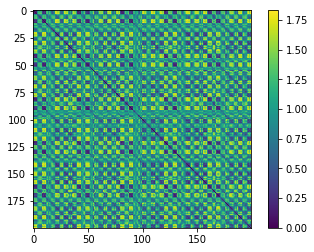

In [5]:
#test on KDEF dataset subset B (note that this is described as dataset A in the paper, and vice versa the dataset that is described as dataset B in the paper is named dataset A in the code)

Dataset_B = pickle.load(open('/mmfs1/data/zhouabx/KDEF/data_B_with_id_expression_direction.pkl', "rb"))   
KDEF_transform = transforms.Compose([transforms.Resize((128, 128)),
                                     transforms.ToTensor()])


feature_list_B = []
ResModel.eval()
with torch.no_grad():
    for idx, row in Dataset_B.iterrows():
        image = Image.open(Dataset_B['path'][idx]).convert('RGB')
        image = KDEF_transform(image)
        qvalues, feature_map, second_last_features, third_last_features = ResModel(image[None, :].cuda())
        feature_map = F.adaptive_avg_pool2d(feature_map, (1, 1))
        feature_map = feature_map.view(feature_map.size(0), -1)        
        feature_list_B.append(feature_map[0, :])      
B_features = torch.stack((feature_list_B))

#label everything
dictionary_emotion = {'AF' : 0, 'AN' : 1, 'HA' : 2, 'NE' : 3, 'SA' : 4}
Dataset_B['emotionlabel'] = Dataset_B['expression'].map(dictionary_emotion)

dictionary_view = {'FL' : 0, 'FR' : 1, 'HL' : 2, 'HR' : 3, 'S' : 4}
Dataset_B['viewlabel'] = Dataset_B['direction'].map(dictionary_view)

dictionary_id = {'AF01' : 0, 'AF02' : 1, 'AF03' : 2, 'AF04' : 3, 'AM08' : 4, 'AM10' : 5, 'AM11' : 6, 'AM25': 7}
Dataset_B['idlabel'] = Dataset_B['id'].map(dictionary_id)

#add feature to the dataset
Dataset_B['feature_B'] = B_features.cpu().detach()

#order everything
New_Data_B = Dataset_B.sort_values(by = ['emotionlabel', 'viewlabel', 'idlabel'])
#reset the index and save the dataframe in New_Data_B_with_feature
New_Data_B_with_features = New_Data_B.reset_index(drop = True)

# create array features
array_features_B = [New_Data_B_with_features['feature_B'][0]]
for i in range(1, New_Data_B_with_features.shape[0]):
    array_features_B = np.concatenate((array_features_B, [New_Data_B_with_features['feature_B'][i]]), axis = 0)

# substract baseline
average_vector = np.mean(array_features_B, axis = 0)
centered_data = array_features_B - average_vector

# attach centered_feature
New_Data_B_with_features['centered_feature'] = [centered_data[i] for i in range(len(centered_data))]

# create RDM
l = [None] * 200
for _ in range (len(New_Data_B_with_features)):
    l [New_Data_B_with_features.iloc[_]['idlabel'] + 
       8 * New_Data_B_with_features.iloc[_]['viewlabel'] + 
       8 * 5 * New_Data_B_with_features.iloc[_]['emotionlabel']] = New_Data_B_with_features.iloc[_]['centered_feature']

RDM_B = 1 - np.corrcoef(l)

plt.imshow(RDM_B) ## note that this is named RDM A in the paper
plt.colorbar()

In [10]:
#save RDM value
path = "/data/zhouabx/ResNet-18/ResNetRL/KDEF_test_results_AB/"
with open(path + 'NOV_RDM_value_B.pkl', 'wb') as pickle_out:
     pickle.dump(RDM_B, pickle_out)

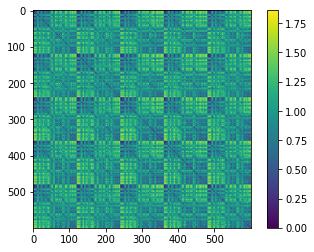

In [6]:
Dataset_A = pickle.load(open('/mmfs1/data/zhouabx/KDEF/data_A_with_id_expression_direction.pkl', "rb"))

features_list_A = []
ResModel.eval()
with torch.no_grad():
    for idx, row in Dataset_A.iterrows():
        image = Image.open(Dataset_A['path'][idx]).convert('RGB')
        image = KDEF_transform(image)
        qvalues, feature_map, second_last_features, third_last_features = ResModel(image[None, :].cuda())
        feature_map = F.adaptive_avg_pool2d(feature_map, (1, 1))
        feature_map = feature_map.view(feature_map.size(0), -1) 
        features_list_A.append(feature_map[0, :])
A_features = torch.stack((features_list_A))
        
Dataset_A['feature_A'] = A_features.cpu().detach()
Dataset_A_with_features = Dataset_A  

#average the L and R         
Dataset_A_with_features["new_direction"] = np.where((Dataset_A_with_features["direction"].values == "HR") | (Dataset_A_with_features["direction"] == "HL"), 
         "H", 
         np.where((Dataset_A_with_features["direction"].values == "FR") | (Dataset_A_with_features["direction"] == "FL"), 
         "F", 
         Dataset_A_with_features["direction"].values))        
         

group_index = Dataset_A_with_features.agg('{0[expression]} and {0[new_direction]} and {0[id]}'.format, axis = 1)

ids = np.unique(group_index)
g_mean = np.array([np.mean(A_features.cpu().detach().numpy()[group_index == i, 0:], axis = 0) for i in ids])

df_LR_ave = pd.DataFrame(data = np.array(list(map(lambda x : np.str.split(x, sep = " and "), ids))))
df_LR_ave.columns = ["expression", "direction", "id"]
df_LR_ave['feature_A'] = g_mean.tolist()
                
#label everything
dictionary_emotion_A = {'AF' : 0, 'AN' : 1, 'HA' : 2, 'NE' : 3, 'SA' : 4}
df_LR_ave['emotionlabel_A'] = df_LR_ave['expression'].map(dictionary_emotion_A)

dictionary_view_A = {'F' : 0, 'H' : 1, 'S' : 2}
df_LR_ave['viewlabel_A'] = df_LR_ave['direction'].map(dictionary_view_A)

dictionary_id_A = {'AF01' : 0, 'AF02' : 1, 'AF03' : 2, 'AF04' : 3, 'AF06' : 4, 'AF07' : 5, 'AF09' : 6, 'AF13' : 7, 'AF14' : 8, 'AF16' : 9,
 'AF20' : 10, 'AF21' : 11, 'AF22' : 12, 'AF24' : 13, 'AF25': 14, 'AF28' : 15, 'AF29' : 16, 'AF30' : 17, 'AF32' : 18, 
 'AF33' : 19, 'AM01' : 20, 'AM05' : 21, 'AM06' : 22, 'AM08' : 23, 'AM09' : 24, 'AM10' : 25, 'AM11' : 26, 'AM13' : 27,
 'AM14' : 28, 'AM15' : 29, 'AM16' : 30, 'AM22' : 31, 'AM23' : 32, 'AM24' : 33, 'AM25' : 34, 'AM28' : 35, 'AM29' : 36,
 'AM30' : 37, 'AM31' : 38, 'AM35' : 39}
df_LR_ave['idlabel_A'] = df_LR_ave['id'].map(dictionary_id_A)

#order everything
New_Data_A = df_LR_ave.sort_values(by = ['emotionlabel_A', 'viewlabel_A', 'idlabel_A'])
#reset the index and save the dataframe in New_Data_A_with_features
New_Data_A_with_features = New_Data_A.reset_index(drop = True)  

# create array features
array_features_A = [New_Data_A_with_features['feature_A'][0]]
for i in range(1, New_Data_A_with_features.shape[0]):
    array_features_A = np.concatenate((array_features_A, [New_Data_A_with_features['feature_A'][i]]), axis = 0)

# substract baseline
average_vector = np.mean(array_features_A, axis = 0)
centered_data = array_features_A - average_vector

# attach centered_feature
New_Data_A_with_features['centered_feature'] = [centered_data[i] for i in range(len(centered_data))]


l_A = [None] * 600
for _ in range (len(New_Data_A_with_features)):
    l_A [New_Data_A_with_features.iloc[_]['idlabel_A'] + 
         40 * New_Data_A_with_features.iloc[_]['viewlabel_A'] + 
         40 * 3 * New_Data_A_with_features.iloc[_]['emotionlabel_A']] = New_Data_A_with_features.iloc[_]['centered_feature']      

RDM_A = 1 - np.corrcoef(l_A)      

plt.imshow(RDM_A) ## note that this is named RDM B in the paper
plt.colorbar()

In [8]:
#save RDM value
path = "/data/zhouabx/ResNet-18/ResNetRL/KDEF_test_results_AB/"
with open(path + 'NOV_RDM_value_A.pkl', 'wb') as pickle_out:
     pickle.dump(RDM_A, pickle_out)

In [2]:
# KDEF A & B
ResRL_RDM_value_A = pickle.load(open('/mmfs1/data/zhouabx/ResNet-18/ResNetRL/KDEF_test_results_AB/NOV_RDM_value_A.pkl',"rb"))
v_ResRL_RDM_A = ResRL_RDM_value_A[np.triu_indices(ResRL_RDM_value_A.shape[0], 1)]

ResRL_RDM_value_B = pickle.load(open('/mmfs1/data/zhouabx/ResNet-18/ResNetRL/KDEF_test_results_AB/NOV_RDM_value_B.pkl',"rb"))
v_ResRL_RDM_B = ResRL_RDM_value_B[np.triu_indices(ResRL_RDM_value_B.shape[0], 1)]

In [3]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p16/'
vA_p16_rdms = []
v_vA_p16_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vA_p16_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p16_rdms)):
    vector = vA_p16_rdms[i][np.triu_indices(vA_p16_rdms[i].shape[0], 1)]
    v_vA_p16_rdms.append(vector)
    
kendalltau_ResRL_and_vA_p16 = []
for i in range (len(v_vA_p16_rdms)):   
    kendalltau_ResRL_and_vA_p16.append(stats.kendalltau(v_ResRL_RDM_A, v_vA_p16_rdms[i]))
    
corr, _ = kendalltau_ResRL_and_vA_p16[0]
print('subset A ResNet_RL and p16_e90_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p16[1]
print('subset A ResNet_RL and p16_e90_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p16[2]
print('subset A ResNet_RL and p16_e90_wind6 kendalltau: %.5f' % corr)

subset A ResNet_RL and p16_e90_wind4 kendalltau: 0.01209
subset A ResNet_RL and p16_e90_wind5 kendalltau: 0.01652
subset A ResNet_RL and p16_e90_wind6 kendalltau: 0.00814


In [4]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p23/'
vA_p23_rdms = []
v_vA_p23_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p23_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p23_rdms)):
    vector = vA_p23_rdms[i][np.triu_indices(vA_p23_rdms[i].shape[0], 1)]
    v_vA_p23_rdms.append(vector)
    
kendalltau_ResRL_and_vA_p23 = []
for i in range (len(v_vA_p23_rdms)):   
    kendalltau_ResRL_and_vA_p23.append(stats.kendalltau(v_ResRL_RDM_A, v_vA_p23_rdms[i]))

corr, _ = kendalltau_ResRL_and_vA_p23[0]
print('subset A ResNet_RL and p23_wind4 kendalltau: 0')
corr, _ = kendalltau_ResRL_and_vA_p23[1]
print('subset A ResNet_RL and p23_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p23[2]
print('subset A ResNet_RL and p23_wind6 kendalltau:: %.5f' % corr)

subset A ResNet_RL and p23_wind4 kendalltau: 0
subset A ResNet_RL and p23_wind5 kendalltau: 0.00128
subset A ResNet_RL and p23_wind6 kendalltau:: 0.00034


In [5]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p27/'
vA_p27_rdms = []
v_vA_p27_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p27_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p27_rdms)):
    vector = vA_p27_rdms[i][np.triu_indices(vA_p27_rdms[i].shape[0], 1)]
    v_vA_p27_rdms.append(vector)
    
kendalltau_ResRL_and_vA_p27 = []
for i in range (len(v_vA_p27_rdms)):   
    kendalltau_ResRL_and_vA_p27.append(stats.kendalltau(v_ResRL_RDM_A, v_vA_p27_rdms[i]))

corr, _ = kendalltau_ResRL_and_vA_p27[0]
print('subset A ResNet_RL and p27_e100_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p27[1]
print('subset A ResNet_RL and p27_e100_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p27[2]
print('subset A ResNet_RL and p27_e100_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p27[3]
print('subset A ResNet_RL and p27_e53_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p27[4]
print('subset A ResNet_RL and p27_e53_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p27[5]
print('subset A ResNet_RL and p27_e53_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p27[6]
print('subset A ResNet_RL and p27_e60_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p27[7]
print('subset A ResNet_RL and p27_e60_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p27[8]
print('subset A ResNet_RL and p27_e60_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p27[9]
print('subset A ResNet_RL and p27_e61_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p27[10]
print('subset A ResNet_RL and p27_e61_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p27[11]
print('subset A ResNet_RL and p27_e61_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p27[12]
print('subset A ResNet_RL and p27_e62_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p27[13]
print('subset A ResNet_RL and p27_e62_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p27[14]
print('subset A ResNet_RL and p27_e62_wind6 kendalltau: %.5f' % corr)

subset A ResNet_RL and p27_e100_wind4 kendalltau: 0.03236
subset A ResNet_RL and p27_e100_wind5 kendalltau: 0.01992
subset A ResNet_RL and p27_e100_wind6 kendalltau: 0.00900
subset A ResNet_RL and p27_e53_wind4 kendalltau: 0.03469
subset A ResNet_RL and p27_e53_wind5 kendalltau: 0.05260
subset A ResNet_RL and p27_e53_wind6 kendalltau: 0.02335
subset A ResNet_RL and p27_e60_wind4 kendalltau: 0.00836
subset A ResNet_RL and p27_e60_wind5 kendalltau: 0.02151
subset A ResNet_RL and p27_e60_wind6 kendalltau: 0.00440
subset A ResNet_RL and p27_e61_wind4 kendalltau: 0.00585
subset A ResNet_RL and p27_e61_wind5 kendalltau: 0.03344
subset A ResNet_RL and p27_e61_wind6 kendalltau: 0.01672
subset A ResNet_RL and p27_e62_wind4 kendalltau: 0.04149
subset A ResNet_RL and p27_e62_wind5 kendalltau: 0.04462
subset A ResNet_RL and p27_e62_wind6 kendalltau: 0.01622


In [6]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p28/'
vA_p28_rdms = []
v_vA_p28_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vA_p28_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p28_rdms)):
    vector = vA_p28_rdms[i][np.triu_indices(vA_p28_rdms[i].shape[0], 1)]
    v_vA_p28_rdms.append(vector)
    
kendalltau_ResRL_and_vA_p28 = []
for i in range (len(v_vA_p28_rdms)):   
    kendalltau_ResRL_and_vA_p28.append(stats.kendalltau(v_ResRL_RDM_A, v_vA_p28_rdms[i]))

corr, _ = kendalltau_ResRL_and_vA_p28[0]
print('subset A ResNet_RL and p28_e85_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p28[1]
print('subset A ResNet_RL and p28_e85_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p28[2]
print('subset A ResNet_RL and p28_e85_wind6 kendalltau: %.5f' % corr)

subset A ResNet_RL and p28_e85_wind4 kendalltau: 0.03958
subset A ResNet_RL and p28_e85_wind5 kendalltau: 0.00598
subset A ResNet_RL and p28_e85_wind6 kendalltau: 0.00285


In [7]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p30/'
vA_p30_rdms = []
v_vA_p30_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p30_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p30_rdms)):
    vector = vA_p30_rdms[i][np.triu_indices(vA_p30_rdms[i].shape[0], 1)]
    v_vA_p30_rdms.append(vector)
    
kendalltau_ResRL_and_vA_p30 = []
for i in range (len(v_vA_p30_rdms)):   
    kendalltau_ResRL_and_vA_p30.append(stats.kendalltau(v_ResRL_RDM_A, v_vA_p30_rdms[i]))

corr, _ = kendalltau_ResRL_and_vA_p30[0]
print('subset A ResNet_RL and p30_e8_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p30[1]
print('subset A ResNet_RL and p30_e8_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p30[2]
print('subset A ResNet_RL and p30_e8_wind6 kendalltau: %.5f' % corr)

subset A ResNet_RL and p30_e8_wind4 kendalltau: 0.00014
subset A ResNet_RL and p30_e8_wind5 kendalltau: 0.00024
subset A ResNet_RL and p30_e8_wind6 kendalltau: 0.00082


In [8]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p34/'
vA_p34_rdms = []
v_vA_p34_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p34_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p34_rdms)):
    vector = vA_p34_rdms[i][np.triu_indices(vA_p34_rdms[i].shape[0], 1)]
    v_vA_p34_rdms.append(vector)
    
kendalltau_ResRL_and_vA_p34 = []
for i in range (len(v_vA_p34_rdms)):   
    kendalltau_ResRL_and_vA_p34.append(stats.kendalltau(v_ResRL_RDM_A, v_vA_p34_rdms[i]))

corr, _ = kendalltau_ResRL_and_vA_p34[0]
print('subset A ResNet_RL and p34_e23_wind4 kendalltau: 0')
corr, _ = kendalltau_ResRL_and_vA_p34[1]
print('subset A ResNet_RL and p34_e23_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p34[2]
print('subset A ResNet_RL and p34_e23_wind6 kendalltau: 0')
corr, _ = kendalltau_ResRL_and_vA_p34[3]
print('subset A ResNet_RL and p34_e42_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p34[4]
print('subset A ResNet_RL and p34_e42_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p34[5]
print('subset A ResNet_RL and p34_e42_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p34[6]
print('subset A ResNet_RL and p34_e44_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p34[7]
print('subset A ResNet_RL and p34_e44_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p34[8]
print('subset A ResNet_RL and p34_e44_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p34[9]
print('subset A ResNet_RL and p43_e43_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p34[10]
print('subset A ResNet_RL and p43_e43_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p34[11]
print('subset A ResNet_RL and p43_e43_wind6 kendalltau: %.5f' % corr)

subset A ResNet_RL and p34_e23_wind4 kendalltau: 0
subset A ResNet_RL and p34_e23_wind5 kendalltau: 0.00217
subset A ResNet_RL and p34_e23_wind6 kendalltau: 0
subset A ResNet_RL and p34_e42_wind4 kendalltau: 0.02580
subset A ResNet_RL and p34_e42_wind5 kendalltau: 0.00539
subset A ResNet_RL and p34_e42_wind6 kendalltau: 0.00218
subset A ResNet_RL and p34_e44_wind4 kendalltau: 0.01389
subset A ResNet_RL and p34_e44_wind5 kendalltau: 0.01963
subset A ResNet_RL and p34_e44_wind6 kendalltau: 0.00481
subset A ResNet_RL and p43_e43_wind4 kendalltau: 0.05773
subset A ResNet_RL and p43_e43_wind5 kendalltau: 0.03848
subset A ResNet_RL and p43_e43_wind6 kendalltau: 0.00606


In [9]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p36/'
vA_p36_rdms = []
v_vA_p36_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vA_p36_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p36_rdms)):
    vector = vA_p36_rdms[i][np.triu_indices(vA_p36_rdms[i].shape[0], 1)]
    v_vA_p36_rdms.append(vector)
    
kendalltau_ResRL_and_vA_p36 = []
for i in range (len(v_vA_p36_rdms)):   
    kendalltau_ResRL_and_vA_p36.append(stats.kendalltau(v_ResRL_RDM_A, v_vA_p36_rdms[i]))

corr, _ = kendalltau_ResRL_and_vA_p36[0]
print('subset A ResNet_RL and p36_e64_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p36[1]
print('subset A ResNet_RL and p36_e64_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p36[2]
print('subset A ResNet_RL and p36_e64_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p36[3]
print('subset A ResNet_RL and p36_e69_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p36[4]
print('subset A ResNet_RL and p36_e69_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p36[5]
print('subset A ResNet_RL and p36_e69_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p36[6]
print('subset A ResNet_RL and p36_e70_wind4 kendalltau: 0')
corr, _ = kendalltau_ResRL_and_vA_p36[7]
print('subset A ResNet_RL and p36_e70_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vA_p36[8]
print('subset A ResNet_RL and p36_e70_wind6 kendalltau: %.5f' % corr)

subset A ResNet_RL and p36_e64_wind4 kendalltau: 0.04722
subset A ResNet_RL and p36_e64_wind5 kendalltau: 0.04273
subset A ResNet_RL and p36_e64_wind6 kendalltau: 0.03047
subset A ResNet_RL and p36_e69_wind4 kendalltau: 0.00063
subset A ResNet_RL and p36_e69_wind5 kendalltau: 0.00194
subset A ResNet_RL and p36_e69_wind6 kendalltau: 0.00476
subset A ResNet_RL and p36_e70_wind4 kendalltau: 0
subset A ResNet_RL and p36_e70_wind5 kendalltau: 0.00194
subset A ResNet_RL and p36_e70_wind6 kendalltau: 0.00230


In [10]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vA/p39/'
vA_p39_rdms = []
v_vA_p39_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path)):
    # print (data_file)
    vA_p39_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vA_p39_rdms)):
    vector = vA_p39_rdms[i][np.triu_indices(vA_p39_rdms[i].shape[0], 1)]
    v_vA_p39_rdms.append(vector)
    
kendalltau_ResRL_and_vA_p39 = []
for i in range (len(v_vA_p39_rdms)):   
    kendalltau_ResRL_and_vA_p39.append(stats.kendalltau(v_ResRL_RDM_A, v_vA_p39_rdms[i]))

corr, _ = kendalltau_ResRL_and_vA_p39[0]
print('subset A ResNet_RL and p39_wind4 kendalltau: 0')
corr, _ = kendalltau_ResRL_and_vA_p39[1]
print('subset A ResNet_RL and p39_wind5 kendalltau: 0')
corr, _ = kendalltau_ResRL_and_vA_p39[2]
print('subset A ResNet_RL and p39_wind6 kendalltau: 0')

subset A ResNet_RL and p39_wind4 kendalltau: 0
subset A ResNet_RL and p39_wind5 kendalltau: 0
subset A ResNet_RL and p39_wind6 kendalltau: 0


In [11]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vB/p41/'
vB_p41_rdms = []
v_vB_p41_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vB_p41_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vB_p41_rdms)):
    vector = vB_p41_rdms[i][np.triu_indices(vB_p41_rdms[i].shape[0], 1)]
    v_vB_p41_rdms.append(vector)
    
kendalltau_ResRL_and_vB_p41 = []
for i in range (len(v_vB_p41_rdms)):   
    kendalltau_ResRL_and_vB_p41.append(stats.kendalltau(v_ResRL_RDM_B, v_vB_p41_rdms[i]))

corr, _ = kendalltau_ResRL_and_vB_p41[1]
print('subset B ResNet_RL and p41_e10_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vB_p41[2]
print('subset B ResNet_RL and p41_e10_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vB_p41[3]
print('subset B ResNet_RL and p41_e10_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vB_p41[7]
print('subset B ResNet_RL and p41_e11_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vB_p41[8]
print('subset B ResNet_RL and p41_e11_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vB_p41[9]
print('subset B ResNet_RL and p41_e11_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vB_p41[13]
print('subset B ResNet_RL and p41_e12_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vB_p41[14]
print('subset B ResNet_RL and p41_e12_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vB_p41[15]
print('subset B ResNet_RL and p41_e12_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vB_p41[19]
print('subset B ResNet_RL and p41_e2_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vB_p41[20]
print('subset B ResNet_RL and p41_e2_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vB_p41[21]
print('subset B ResNet_RL and p41_e2_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vB_p41[25]
print('subset B ResNet_RL and p41_e24_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vB_p41[26]
print('subset B ResNet_RL and p41_e24_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vB_p41[27]
print('subset B ResNet_RL and p41_e24_wind6 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vB_p41[31]
print('subset B ResNet_RL and p41_e9_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vB_p41[32]
print('subset B ResNet_RL and p41_e9_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vB_p41[33]
print('subset B ResNet_RL and p41_e9_wind6 kendalltau: %.5f' % corr)

subset B ResNet_RL and p41_e10_wind4 kendalltau: 0.08867
subset B ResNet_RL and p41_e10_wind5 kendalltau: 0.10780
subset B ResNet_RL and p41_e10_wind6 kendalltau: 0.00470
subset B ResNet_RL and p41_e11_wind4 kendalltau: 0.05670
subset B ResNet_RL and p41_e11_wind5 kendalltau: 0.04965
subset B ResNet_RL and p41_e11_wind6 kendalltau: 0.01659
subset B ResNet_RL and p41_e12_wind4 kendalltau: 0.02712
subset B ResNet_RL and p41_e12_wind5 kendalltau: 0.00798
subset B ResNet_RL and p41_e12_wind6 kendalltau: 0.03084
subset B ResNet_RL and p41_e2_wind4 kendalltau: 0.06641
subset B ResNet_RL and p41_e2_wind5 kendalltau: 0.02837
subset B ResNet_RL and p41_e2_wind6 kendalltau: 0.00729
subset B ResNet_RL and p41_e24_wind4 kendalltau: 0.04000
subset B ResNet_RL and p41_e24_wind5 kendalltau: 0.01457
subset B ResNet_RL and p41_e24_wind6 kendalltau: 0.01112
subset B ResNet_RL and p41_e9_wind4 kendalltau: 0.07582
subset B ResNet_RL and p41_e9_wind5 kendalltau: 0.07674
subset B ResNet_RL and p41_e9_wind6 

In [12]:
folder_path = '/mmfs1/data/zhouabx/iEEG_rdms/data/vB/fusiform_reliable/p47/'
vB_p47_rdms = []
v_vB_p47_rdms = []

# get RDMs
for data_file in sorted(os.listdir(folder_path))[1:]:
    # print (data_file)
    vB_p47_rdms.append(scipy.io.loadmat(folder_path + data_file).get("disMatwind"))
    
for i in range (len(vB_p47_rdms)):
    vector = vB_p47_rdms[i][np.triu_indices(vB_p47_rdms[i].shape[0], 1)]
    v_vB_p47_rdms.append(vector)

kendalltau_ResRL_and_vB_p47 = []
for i in range (len(v_vB_p47_rdms)):   
    kendalltau_ResRL_and_vB_p47.append(stats.kendalltau(v_ResRL_RDM_B, v_vB_p47_rdms[i]))

corr, _ = kendalltau_ResRL_and_vB_p47[1]
print('subset B ResNet_RL and p47_e34_wind4 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vB_p47[2]
print('subset B ResNet_RL and p47_e34_wind5 kendalltau: %.5f' % corr)
corr, _ = kendalltau_ResRL_and_vB_p47[3]
print('subset B ResNet_RL and p47_e34_wind6 kendalltau: %.5f' % corr)

subset B ResNet_RL and p47_e34_wind4 kendalltau: 0.07360
subset B ResNet_RL and p47_e34_wind5 kendalltau: 0.04334
subset B ResNet_RL and p47_e34_wind6 kendalltau: 0.00569


In [ ]:
# path = "/data/zhouabx/ResNet-18/ResNetRL/KDEF_test_results_AB/NOV_kendalltaus/"
ResRL_tau_wind4 = np.array([kendalltau_ResRL_and_vA_p16[0][0],
                            0,
                            kendalltau_ResRL_and_vA_p27[0][0],
                            kendalltau_ResRL_and_vA_p27[3][0],
                            kendalltau_ResRL_and_vA_p27[6][0],
                            kendalltau_ResRL_and_vA_p27[9][0],
                            kendalltau_ResRL_and_vA_p27[12][0],
                            kendalltau_ResRL_and_vA_p28[0][0],
                            kendalltau_ResRL_and_vA_p30[0][0],
                            0,
                            kendalltau_ResRL_and_vA_p34[3][0],
                            kendalltau_ResRL_and_vA_p34[6][0],
                            kendalltau_ResRL_and_vA_p34[9][0],
                            kendalltau_ResRL_and_vA_p36[0][0],
                            kendalltau_ResRL_and_vA_p36[3][0],
                            0,
                            0,
                            kendalltau_ResRL_and_vB_p41[1][0],
                            kendalltau_ResRL_and_vB_p41[7][0],
                            kendalltau_ResRL_and_vB_p41[13][0],
                            kendalltau_ResRL_and_vB_p41[19][0],
                            kendalltau_ResRL_and_vB_p41[25][0],
                            kendalltau_ResRL_and_vB_p41[31][0],
                            kendalltau_ResRL_and_vB_p47[1][0]])

ResRL_tau_wind4_mean = np.mean(ResRL_tau_wind4)
ResRL_tau_wind4_sem = sem(ResRL_tau_wind4)

# with open(path + 'ResRL_tau_wind4.pkl', 'wb') as pickle_out:
#      pickle.dump(ResRL_tau_wind4, pickle_out)      
# with open(path + 'ResRL_tau_wind4_mean.pkl', 'wb') as pickle_out:
#      pickle.dump(ResRL_tau_wind4_mean, pickle_out) 
# with open(path + 'ResRL_tau_wind4_sem.pkl', 'wb') as pickle_out:
#      pickle.dump(ResRL_tau_wind4_sem, pickle_out) 


ResRL_tau_wind5 = np.array([kendalltau_ResRL_and_vA_p16[1][0],
                            kendalltau_ResRL_and_vA_p23[1][0],
                            kendalltau_ResRL_and_vA_p27[1][0],
                            kendalltau_ResRL_and_vA_p27[4][0],
                            kendalltau_ResRL_and_vA_p27[7][0],
                            kendalltau_ResRL_and_vA_p27[10][0],
                            kendalltau_ResRL_and_vA_p27[13][0],
                            kendalltau_ResRL_and_vA_p28[1][0],
                            kendalltau_ResRL_and_vA_p30[1][0],
                            kendalltau_ResRL_and_vA_p34[1][0],
                            kendalltau_ResRL_and_vA_p34[4][0],
                            kendalltau_ResRL_and_vA_p34[7][0],
                            kendalltau_ResRL_and_vA_p34[10][0],
                            kendalltau_ResRL_and_vA_p36[1][0],
                            kendalltau_ResRL_and_vA_p36[4][0],
                            kendalltau_ResRL_and_vA_p36[7][0],
                            0,
                            kendalltau_ResRL_and_vB_p41[2][0],
                            kendalltau_ResRL_and_vB_p41[8][0],
                            kendalltau_ResRL_and_vB_p41[14][0],
                            kendalltau_ResRL_and_vB_p41[20][0],
                            kendalltau_ResRL_and_vB_p41[26][0],
                            kendalltau_ResRL_and_vB_p41[32][0],
                            kendalltau_ResRL_and_vB_p47[2][0]])

ResRL_tau_wind5_mean = np.mean(ResRL_tau_wind5)
ResRL_tau_wind5_sem = sem(ResRL_tau_wind5)

# with open(path + 'ResRL_tau_wind5.pkl', 'wb') as pickle_out:
#      pickle.dump(ResRL_tau_wind5, pickle_out)      
# with open(path + 'ResRL_tau_wind5_mean.pkl', 'wb') as pickle_out:
#      pickle.dump(ResRL_tau_wind5_mean, pickle_out) 
# with open(path + 'ResRL_tau_wind5_sem.pkl', 'wb') as pickle_out:
#      pickle.dump(ResRL_tau_wind5_sem, pickle_out) 


ResRL_tau_wind6 = np.array([kendalltau_ResRL_and_vA_p16[2][0],
                            kendalltau_ResRL_and_vA_p23[2][0],
                            kendalltau_ResRL_and_vA_p27[2][0],
                            kendalltau_ResRL_and_vA_p27[5][0],
                            kendalltau_ResRL_and_vA_p27[8][0],
                            kendalltau_ResRL_and_vA_p27[11][0],
                            kendalltau_ResRL_and_vA_p27[14][0],
                            kendalltau_ResRL_and_vA_p28[2][0],
                            kendalltau_ResRL_and_vA_p30[2][0],
                            0,
                            kendalltau_ResRL_and_vA_p34[5][0],
                            kendalltau_ResRL_and_vA_p34[8][0],
                            kendalltau_ResRL_and_vA_p34[11][0],
                            kendalltau_ResRL_and_vA_p36[2][0],
                            kendalltau_ResRL_and_vA_p36[5][0],
                            kendalltau_ResRL_and_vA_p36[8][0],
                            0,
                            kendalltau_ResRL_and_vB_p41[3][0],
                            kendalltau_ResRL_and_vB_p41[9][0],
                            kendalltau_ResRL_and_vB_p41[15][0],
                            kendalltau_ResRL_and_vB_p41[21][0],
                            kendalltau_ResRL_and_vB_p41[27][0],
                            kendalltau_ResRL_and_vB_p41[33][0],
                            kendalltau_ResRL_and_vB_p47[3][0]])

ResRL_tau_wind6_mean = np.mean(ResRL_tau_wind6)
ResRL_tau_wind6_sem = sem(ResRL_tau_wind6)

# with open(path + 'ResRL_tau_wind6.pkl', 'wb') as pickle_out:
#      pickle.dump(ResRL_tau_wind6, pickle_out)      
# with open(path + 'ResRL_tau_wind6_mean.pkl', 'wb') as pickle_out:
#      pickle.dump(ResRL_tau_wind6_mean, pickle_out) 
# with open(path + 'ResRL_tau_wind6_sem.pkl', 'wb') as pickle_out:
#      pickle.dump(ResRL_tau_wind6_sem, pickle_out) 

In [21]:
d_ResRL_tau_wind4 = {'value': [kendalltau_ResRL_and_vA_p16[0][0],
                            0,
                            kendalltau_ResRL_and_vA_p27[0][0],
                            kendalltau_ResRL_and_vA_p27[3][0],
                            kendalltau_ResRL_and_vA_p27[6][0],
                            kendalltau_ResRL_and_vA_p27[9][0],
                            kendalltau_ResRL_and_vA_p27[12][0],
                            kendalltau_ResRL_and_vA_p28[0][0],
                            kendalltau_ResRL_and_vA_p30[0][0],
                            0,
                            kendalltau_ResRL_and_vA_p34[3][0],
                            kendalltau_ResRL_and_vA_p34[6][0],
                            kendalltau_ResRL_and_vA_p34[9][0],
                            kendalltau_ResRL_and_vA_p36[0][0],
                            kendalltau_ResRL_and_vA_p36[3][0],
                            0,
                            0,
                            kendalltau_ResRL_and_vB_p41[1][0],
                            kendalltau_ResRL_and_vB_p41[7][0],
                            kendalltau_ResRL_and_vB_p41[13][0],
                            kendalltau_ResRL_and_vB_p41[19][0],
                            kendalltau_ResRL_and_vB_p41[25][0],
                            kendalltau_ResRL_and_vB_p41[31][0],
                            kendalltau_ResRL_and_vB_p47[1][0]], 
     'window': ['window4'] * len(ResRL_tau_wind4), 
     'subject': [16, 23, 27, 27, 27, 27, 27, 28, 30, 34, 34, 34, 34, 36, 36, 36, 39, 41, 41, 41, 41, 41, 41, 47], 
     'model': ['ResNet RL'] * len(ResRL_tau_wind4)}
ResRL_tau_wind4 = pd.DataFrame(data = d_ResRL_tau_wind4)

d_ResRL_tau_wind5 = {'value': [kendalltau_ResRL_and_vA_p16[1][0],
                            kendalltau_ResRL_and_vA_p23[1][0],
                            kendalltau_ResRL_and_vA_p27[1][0],
                            kendalltau_ResRL_and_vA_p27[4][0],
                            kendalltau_ResRL_and_vA_p27[7][0],
                            kendalltau_ResRL_and_vA_p27[10][0],
                            kendalltau_ResRL_and_vA_p27[13][0],
                            kendalltau_ResRL_and_vA_p28[1][0],
                            kendalltau_ResRL_and_vA_p30[1][0],
                            kendalltau_ResRL_and_vA_p34[1][0],
                            kendalltau_ResRL_and_vA_p34[4][0],
                            kendalltau_ResRL_and_vA_p34[7][0],
                            kendalltau_ResRL_and_vA_p34[10][0],
                            kendalltau_ResRL_and_vA_p36[1][0],
                            kendalltau_ResRL_and_vA_p36[4][0],
                            kendalltau_ResRL_and_vA_p36[7][0],
                            0,
                            kendalltau_ResRL_and_vB_p41[2][0],
                            kendalltau_ResRL_and_vB_p41[8][0],
                            kendalltau_ResRL_and_vB_p41[14][0],
                            kendalltau_ResRL_and_vB_p41[20][0],
                            kendalltau_ResRL_and_vB_p41[26][0],
                            kendalltau_ResRL_and_vB_p41[32][0],
                            kendalltau_ResRL_and_vB_p47[2][0]], 
     'window': ['window5'] * len(ResRL_tau_wind4), 
     'subject': [16, 23, 27, 27, 27, 27, 27, 28, 30, 34, 34, 34, 34, 36, 36, 36, 39, 41, 41, 41, 41, 41, 41, 47], 
     'model': ['ResNet RL'] * len(ResRL_tau_wind4)}
ResRL_tau_wind5 = pd.DataFrame(data = d_ResRL_tau_wind5)

d_ResRL_tau_wind6 = {'value': [kendalltau_ResRL_and_vA_p16[2][0],
                            kendalltau_ResRL_and_vA_p23[2][0],
                            kendalltau_ResRL_and_vA_p27[2][0],
                            kendalltau_ResRL_and_vA_p27[5][0],
                            kendalltau_ResRL_and_vA_p27[8][0],
                            kendalltau_ResRL_and_vA_p27[11][0],
                            kendalltau_ResRL_and_vA_p27[14][0],
                            kendalltau_ResRL_and_vA_p28[2][0],
                            kendalltau_ResRL_and_vA_p30[2][0],
                            0,
                            kendalltau_ResRL_and_vA_p34[5][0],
                            kendalltau_ResRL_and_vA_p34[8][0],
                            kendalltau_ResRL_and_vA_p34[11][0],
                            kendalltau_ResRL_and_vA_p36[2][0],
                            kendalltau_ResRL_and_vA_p36[5][0],
                            kendalltau_ResRL_and_vA_p36[8][0],
                            0,
                            kendalltau_ResRL_and_vB_p41[3][0],
                            kendalltau_ResRL_and_vB_p41[9][0],
                            kendalltau_ResRL_and_vB_p41[15][0],
                            kendalltau_ResRL_and_vB_p41[21][0],
                            kendalltau_ResRL_and_vB_p41[27][0],
                            kendalltau_ResRL_and_vB_p41[33][0],
                            kendalltau_ResRL_and_vB_p47[3][0]], 
     'window': ['window6'] * len(ResRL_tau_wind4), 
     'subject': [16, 23, 27, 27, 27, 27, 27, 28, 30, 34, 34, 34, 34, 36, 36, 36, 39, 41, 41, 41, 41, 41, 41, 47], 
     'model': ['ResNet RL'] * len(ResRL_tau_wind4)}
ResRL_tau_wind6 = pd.DataFrame(data = d_ResRL_tau_wind6)

ResRL = pd.concat([ResRL_tau_wind4, ResRL_tau_wind5, ResRL_tau_wind6])
ResRL

,value,window,subject,model
0,0.012089,window4,16,ResNet RL
1,0.000000,window4,23,ResNet RL
2,0.032362,window4,27,ResNet RL
3,0.034691,window4,27,ResNet RL
4,0.008361,window4,27,ResNet RL
...,...,...,...,...
19,0.030836,window6,41,ResNet RL
20,0.007287,window6,41,ResNet RL
21,0.011116,window6,41,ResNet RL
22,0.002950,window6,41,ResNet RL


In [22]:
path = "/data/zhouabx/ResNet-18/ResNetRL/ResRL_ttest_df/"
with open(path + 'ResRL.pkl', 'wb') as pickle_out:
     pickle.dump(ResRL, pickle_out)      